# A Gentle Introduction to Transfer Learning

In [23]:
import sys
import os
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from utils import (get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model, create_dataset, 
                   available_models, plot_metrics)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [27]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 64
SETS = ['train', 'val']
NUM_GPUS = 4
EPOCHS = 25
LR = 0.001
LR_STEP = 0.1
LR_EPOCHS = 7
MOMENTUM = 0.9

## Model and utilities

In [4]:
model_names = available_models()
print(model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [29]:
def finetune(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # All parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, sets, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
    return model_ft

In [30]:
def freeze_and_train(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for param in model_conv.parameters(): #params have requires_grad=True by default
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # Only parameters of final layer are being optimized 
    optimizer = SGD(model_conv.fc.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
    return model_conv

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [7]:
DATA_ROOT = '/datadrive'
HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')
SIMPSONS_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons')

In [8]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


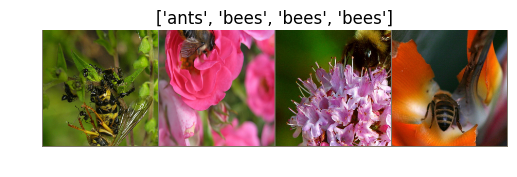

In [9]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [ ]:
data_simpsons = create_dataset(SIMPSONS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}


In [ ]:
plot_pytorch_data_stream(data_simpsons['train'], max_images=4)

## Training

In [31]:
model, metrics = finetune(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0219 Acc: 0.5902
val Loss: 0.0183 Acc: 0.6863

Epoch 2/25
----------
train Loss: 0.0160 Acc: 0.7746
val Loss: 0.0118 Acc: 0.8758

Epoch 3/25
----------
train Loss: 0.0128 Acc: 0.8402
val Loss: 0.0089 Acc: 0.8954

Epoch 4/25
----------
train Loss: 0.0089 Acc: 0.9098
val Loss: 0.0074 Acc: 0.9281

Epoch 5/25
----------
train Loss: 0.0102 Acc: 0.8770
val Loss: 0.0066 Acc: 0.9216

Epoch 6/25
----------
train Loss: 0.0092 Acc: 0.9016
val Loss: 0.0061 Acc: 0.9281

Epoch 7/25
----------
train Loss: 0.0083 Acc: 0.8934
val Loss: 0.0065 Acc: 0.9085

Epoch 8/25
----------
train Loss: 0.0074 Acc: 0.9180
val Loss: 0.0063 Acc: 0.9281

Epoch 9/25
----------
train Loss: 0.0091 Acc: 0.8811
val Loss: 0.0073 Acc: 0.9085

Epoch 10/25
----------
train Loss: 0.0082 Acc: 0.9016
val Loss: 0.0062 Acc: 0.9216

Epoch 11/25
----------
train Loss: 0.0068 Acc: 0.9221
val Loss: 0.0061 Acc: 0.9216

Epoch 12/25
----------
train Loss: 0.0061 Acc: 0.9262
val Loss: 0.0064 Acc: 0.9346



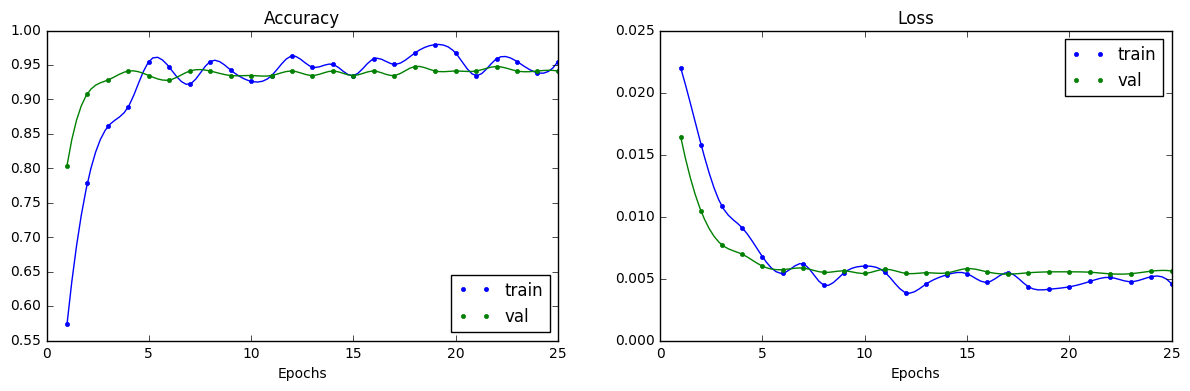

In [17]:
plot_metrics(metrics)

In [18]:
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0272 Acc: 0.3811
val Loss: 0.0246 Acc: 0.4706

Epoch 2/25
----------
train Loss: 0.0199 Acc: 0.6680
val Loss: 0.0151 Acc: 0.8366

Epoch 3/25
----------
train Loss: 0.0142 Acc: 0.8402
val Loss: 0.0107 Acc: 0.9085

Epoch 4/25
----------
train Loss: 0.0118 Acc: 0.8648
val Loss: 0.0087 Acc: 0.9216

Epoch 5/25
----------
train Loss: 0.0115 Acc: 0.8648
val Loss: 0.0080 Acc: 0.9477

Epoch 6/25
----------
train Loss: 0.0083 Acc: 0.9057
val Loss: 0.0077 Acc: 0.9150

Epoch 7/25
----------
train Loss: 0.0086 Acc: 0.8975
val Loss: 0.0077 Acc: 0.9412

Epoch 8/25
----------
train Loss: 0.0071 Acc: 0.9139
val Loss: 0.0069 Acc: 0.9542

Epoch 9/25
----------
train Loss: 0.0072 Acc: 0.9344
val Loss: 0.0070 Acc: 0.9542

Epoch 10/25
----------
train Loss: 0.0072 Acc: 0.9139
val Loss: 0.0069 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.0079 Acc: 0.9098
val Loss: 0.0072 Acc: 0.9477

Epoch 12/25
----------
train Loss: 0.0084 Acc: 0.9139
val Loss: 0.0067 Acc: 0.9412



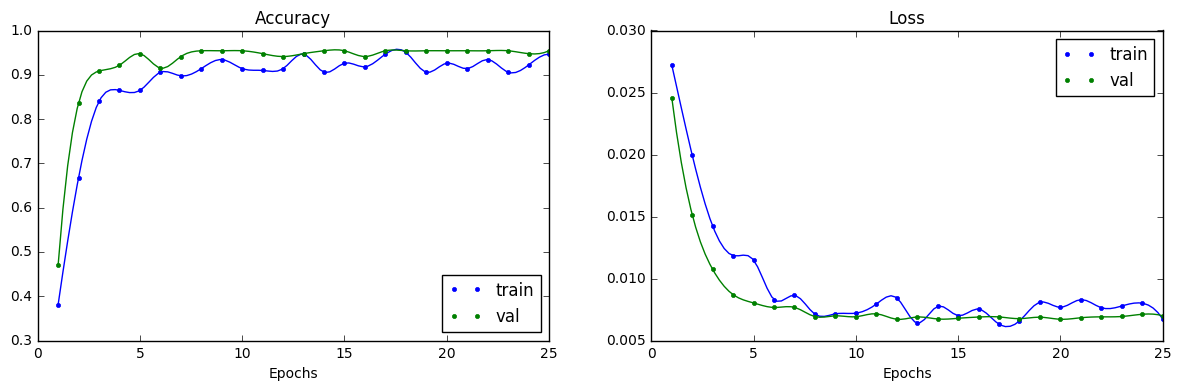

In [19]:
plot_metrics(metrics)

Transfer learning with Simpsons dataset

In [ ]:
model, metrics = finetune(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics)

In [ ]:
model, metrics = freeze_and_train(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics)